<a href="https://colab.research.google.com/github/florestony54/skin-lesion/blob/main/skin_lesion_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Dematoscopic Images of Pigmented Skin Lesions

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import PIL
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image
import pathlib
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model

from math import ceil

# Checking for GPU and device details

In [2]:
devices = device_lib.list_local_devices()
if len(devices) > 1:
  gpu_details = devices[1].physical_device_desc.split(",")
  print("GPU detected: {}".format(gpu_details[1]))
else:
  print("No GPU detected.")


GPU detected:  name: Tesla P100-PCIE-16GB


# Loading Image data and Preprocessing

In [3]:
!mkdir lesion_data

Unzipping raw image data from Drive to the lesion_data directory. Using flow_from_directory() from a mounted Google Drive directory is a huge bottleneck on the training process, so unzipping to a Colab directory here is a necessity.

In [4]:
!unzip -uq "/content/drive/My Drive/lesion_data.zip" -d "/content/lesion_data/"

In [5]:
data_dir = "/content/lesion_data/Takeout/Drive/data"

Here we can see each split of the image data (train/ validation/ test) contains 7 subdirectories, one for each classification.
**Note:** I pulled the dataset from Kaggle, and used a script to organize the images through subdirectories so the keras [flow_from_directory()](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) method can label images and feed them to the network.

In [6]:
data_dir = pathlib.Path(data_dir)
train_dir =os.path.join(data_dir, "train")
val_dir =os.path.join(data_dir, "val")
test_dir=os.path.join(data_dir, "test")

train_count = os.listdir(train_dir)
val_count = os.listdir(val_dir)
test_count = os.listdir(test_dir )
print(len(train_count))
print(len(val_count))
print(len(test_count))

7
7
7


There are 7 labels in this dataset, all corresponding to a different diagnostic category for pingmented skin lesions:
- **vasc** = vascular lesions (angiomas, angiokeratomas, pyogenic granulomas, and hemorrhage)
- **nv** = Melanocytic nevi
- **akiec** = Actinic keratoses/intraepithelial carcinoma
- **df** = Dermatofibroma
- **bcc** = Basal cell carcinoma
- **bkl** = Benign keratosis-like lesions
- **mel** = Melanoma

In [7]:
class_names = os.listdir(train_dir)
class_names

['bcc', 'vasc', 'df', 'akiec', 'nv', 'mel', 'bkl']

Downscaling the images and setting the batch size.

In [8]:
batch_size = 64
img_height = 450//3
img_width = 600//3
target_size = (img_height, img_width)

Here we augment the training images. This step is used to combat overfitting by slightly altering the array representation of the images. Essentially this generates new data for the model to train on. Instead of passing the same image to the model every epoch, ImageDataGenerator will randomly alter the image (e.g. rotate a few degrees, shift to the right a few pixels, etc.) within the constraints of the parameters we set before feeding to the network. 

The data was split 65\15\20 for train\val\test.
 




In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    rotation_range = 20,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
)

In [10]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    shuffle = True,
    seed = 930,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 6411 images belonging to 7 classes.


In [11]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [12]:
val_data = val_datagen.flow_from_directory(
    val_dir,
    shuffle = True,
    seed =930,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1601 images belonging to 7 classes.


# Exploring the Training Image Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


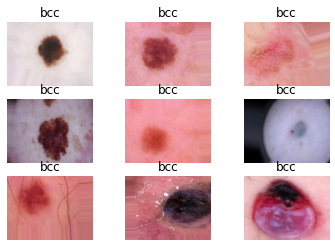

In [13]:
tr_img = train_data.next()

for i in range(9):
  ax = plt.subplot(3,3, i + 1)
  image = tr_img[0][i]
  plt.imshow(image)
  plt.title(class_names[ class_names == tr_img[1][i]])
  plt.axis("off")

In [13]:
from collections import Counter
class_count = Counter(train_data.classes)
class_count_list = []
[class_count_list.append(x) for x in class_count.values()]
class_count_list

[206, 328, 706, 73, 703, 4299, 96]

<BarContainer object of 7 artists>

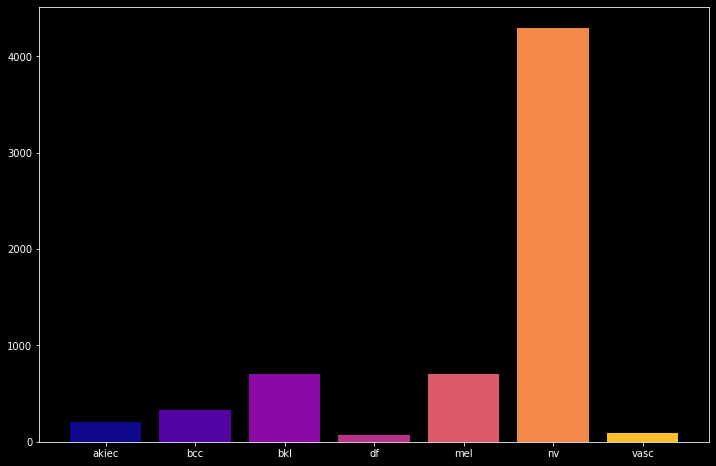

In [15]:
plt.style.use('dark_background')
my_cmap = plt.get_cmap("plasma")
x = np.arange(7).astype(float)
plt.figure(figsize = (12,8))
plt.bar(train_data.class_indices.keys(), 
        height=class_count_list, 
        color=my_cmap(x/7))

This dataset is heavily imbalanced with 'nv' as the majority class. 

# Class Weights
Here we will calculate the class weights for each class, based on their distribution in the training set. Since the dataset is imbalanced we want our model to be more sensitive to classes that are underrepresented, to try and avoid overfitting the majority class (nv in this case)

In [14]:
class_weight = {}

for i in range(7):
  weight_name = "weight_for_" + str(i)
  weight_var = (1 / class_count_list[i])*(6411)/7.0 
  class_weight.update({i: weight_var})
  print('{}: {:.2f}'.format(weight_name, weight_var))

weight_for_0: 4.45
weight_for_1: 2.79
weight_for_2: 1.30
weight_for_3: 12.55
weight_for_4: 1.30
weight_for_5: 0.21
weight_for_6: 9.54


In [15]:
def plot_model_acc(history):
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

# Importing DenseNet121


In [16]:
from tensorflow.keras.applications import DenseNet121
conv_base = DenseNet121(weights='imagenet',
                     include_top=False,
                     input_shape = (img_height, img_width, 3))

conv_base.trainable = False

conv_base.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 100, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 100, 64)  256         conv1/conv[0][0]                 
_______________________

In [17]:
topClassifier = conv_base.output

topClassifier = layers.GlobalAveragePooling2D()(topClassifier)

topClassifier = layers.Dense(7, activation="softmax")(topClassifier)

model = Model(inputs=conv_base.input, outputs=topClassifier)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 100, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 100, 64)  256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [30]:
BATCH_SIZE = 32

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-3, restore_best_weights=True)


history = model.fit(
            train_data,
            validation_data = val_data,
            batch_size = BATCH_SIZE,
            epochs = 50,
            callbacks=callback)

Epoch 1/50
101/101 [==============================] - 109s 1s/step - loss: 1.7399 - accuracy: 0.3168 - val_loss: 1.3185 - val_accuracy: 0.5953
Epoch 2/50
101/101 [==============================] - 102s 1s/step - loss: 1.2795 - accuracy: 0.6437 - val_loss: 1.1707 - val_accuracy: 0.6758
Epoch 3/50
101/101 [==============================] - 102s 1s/step - loss: 1.1371 - accuracy: 0.6789 - val_loss: 1.0920 - val_accuracy: 0.6758
Epoch 4/50
101/101 [==============================] - 102s 1s/step - loss: 1.0750 - accuracy: 0.6722 - val_loss: 1.0418 - val_accuracy: 0.6765
Epoch 5/50
101/101 [==============================] - 103s 1s/step - loss: 1.0198 - accuracy: 0.6788 - val_loss: 1.0078 - val_accuracy: 0.6814
Epoch 6/50
101/101 [==============================] - 102s 1s/step - loss: 0.9904 - accuracy: 0.6853 - val_loss: 0.9783 - val_accuracy: 0.6821
Epoch 7/50
101/101 [==============================] - 103s 1s/step - loss: 0.9770 - accuracy: 0.6776 - val_loss: 0.9526 - val_accuracy: 0.6833

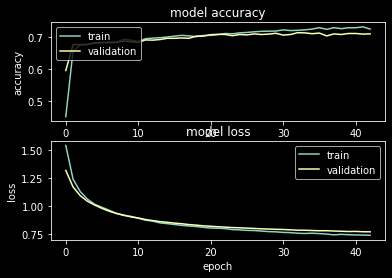

In [31]:
 plot_model_acc(history)

# Fine tuning

In [32]:
conv_base.trainable = True

for layer in conv_base.layers[:-9]:
  layer.trainable=False

for layer in conv_base.layers[-9:]:
  layer.trainable=True


In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=1e-3, restore_best_weights=True)


model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

history = model.fit(
            train_data,
            validation_data = val_data,
            epochs = 100,
            callbacks=callback,
            verbose = 1)

Epoch 1/100
101/101 [==============================] - 109s 1s/step - loss: 1.0408 - accuracy: 0.6498 - val_loss: 0.8219 - val_accuracy: 0.7102
Epoch 2/100
101/101 [==============================] - 102s 1s/step - loss: 0.8969 - accuracy: 0.6908 - val_loss: 0.8487 - val_accuracy: 0.7083
Epoch 3/100
101/101 [==============================] - 102s 1s/step - loss: 0.8096 - accuracy: 0.7111 - val_loss: 0.8569 - val_accuracy: 0.7071
Epoch 4/100
101/101 [==============================] - 102s 1s/step - loss: 0.7888 - accuracy: 0.7169 - val_loss: 0.8585 - val_accuracy: 0.7096
Epoch 5/100
101/101 [==============================] - 102s 1s/step - loss: 0.7708 - accuracy: 0.7288 - val_loss: 0.8542 - val_accuracy: 0.7108
Epoch 6/100
101/101 [==============================] - 102s 1s/step - loss: 0.7474 - accuracy: 0.7352 - val_loss: 0.8506 - val_accuracy: 0.7121
Epoch 7/100
101/101 [==============================] - 102s 1s/step - loss: 0.7605 - accuracy: 0.7300 - val_loss: 0.8470 - val_accuracy:

In [35]:
drive_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'skin_lesion', "skin_lesion_densenet121.h5")
model.save(drive_dir)

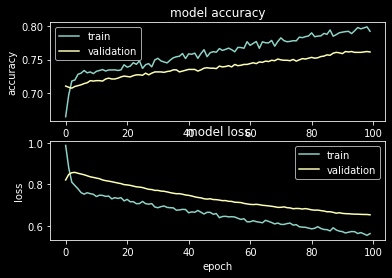

In [36]:
plot_model_acc(history)

In [18]:
model_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'skin_lesion', "skin_lesion_densenet121.h5")
model = keras.models.load_model(model_dir)

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

test_data = val_datagen.flow_from_directory(
    test_dir,
    shuffle = True,
    seed =930,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

y_pred = model.predict(test_data)

Found 2003 images belonging to 7 classes.


In [21]:
test_loss, test_acc = model.evaluate(test_data)
print('test acc:', test_acc)

32/32 [==============================] - 19s 529ms/step - loss: 0.6670 - accuracy: 0.7564
test acc: 0.7563654780387878


In [22]:
predicted_labels = np.argmax(y_pred, axis=1)

true_labels = test_data.classes

In [25]:
cm = confusion_matrix(true_labels, predicted_labels)

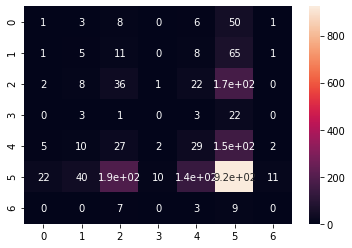

In [26]:
import seaborn as sns
f = sns.heatmap(cm, annot=True)